In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import aipy
import scipy
import linsolve as ls

In [5]:
# %load cvcr.py
import numpy as np

def cvcr(f,g, op='timecv'):
    """Convolves or correlates to arrays.
    op is operation type.
    scv = Return array in original array units(convolution thm)
    scr = return correlation between the two arrays by conjugating the second
    hcv = similiar to scv but ignores inverse fourier transform and returns array in 'Hz'
    hcr = similiar to scr but ignores the inverse fourier transform"""
    
    assert (op in ('timecv','timecr','freqcv','freqcr'))
    #fourier transform functions
    f_fft = np.fft.rfft(f)
    g_fft = np.fft.rfft(g)
    fg = f_fft*g_fft
    fgc = f_fft*g_fft.conj()
    if op=='timecv':
        fcvg = np.fft.irfft(fg)
        return fcvg
    elif op=='timecr':
        fcrg = np.fft.irfft(fgc)
        return fcrg
    elif op=='freqcv':
        return fg
    elif op=='freqcr':
        return fgc



In [12]:
# %load delay.py
import numpy as np

def delay(array, dt, mode='wcon'):
    '''Returns a shifted or wrapped array based on mode 
    Example:

    Shifts and wraps (Shifts only integer type delays)
    >>>delay([1,2,3,4,5], 3)
    array([3,4,5,1,2])

    Shifts and adds guassian noise 
    >>>delay([1,2,3,4,5], 3, 'ncon')
    array([randint, randint, randint, 1, 2])

    'wfft' mode will shift and wrap an array via convolution theorem
    This mode can handle float type delays 
    '''
    assert (mode in ('wcon' , 'ncon', 'wfft')) #select mode from list
    assert (0 <= np.abs(dt) < array.size) #delay out of possible range
    
    if mode =='wcon':
        assert(type(dt) in (int, long))#To do float type delays use wfft
        d_array = np.concatenate((array[dt-array.size:],array[:dt]))
        return d_array
    elif mode=='ncon':
        assert(type(dt) in (int, long))#To do float type delays use wfft
        rand = np.random.rand(dt)
        d_array = np.concatenate((rand, array[:-rand.size]), axis=0)
        return d_array
    elif mode=='wfft': # TODO Improve Tolerance
        f_fft=np.fft.fft(array)
        #returns cycles per second if sample spacing of f is in seconds
        nu = np.fft.fftfreq(array.size)
#         print ' nu is \n' , nu
        #Phase shift(kronecker delta)
        phi = np.exp(-2j * np.pi *nu * dt)
#         print phi
        fcvp = np.fft.ifft(phi * f_fft)
        d_array = fcvp.astype(array.dtype)
        return d_array
    
def mult(signals, elem, tau='n'):
    '''This function serves to create multiple arrays that 
    are delayed by some random amount.
    signals: Number of desired signal arrays
    elem: number of elements in signal array
    ld: lowest delay
    hd: highest delay
    '''
    assert tau in ('n' , 'rand', 'choose')
    n = np.random.randn(signals, elem)
    if tau == 'n':
        return n
    if tau == 'rand':
        ld = input('Enter minimum delay: ')
        hd = input('Enter max delay: ')
        for i in range(signals):
            r = np.random.randint(ld, hd)
            n[i]= delay(n[i], r, 'wfft')
        return n
    if tau =='choose':
        for i in range(signals):
            print('Delay array ' , i+1 , ' by: ')
            r = input()
            n[i]= delay(n[i], r, 'wfft')
        return n

def dmul(a, dt=0, mode='wcon'):
    
    assert (a.shape[1]>0) #dmul only works for array of arrays
    assert mode in ('wcon' , 'rand' , 'wfft')
    for i in range(a.shape[0]):
        if mode =='wfft':
            f_fft=np.fft.fft(a)
            nu = np.fft.fftfreq(a[i].size)
            phi = np.exp(-2j*np.pi*nu*dt)
            fcvp = np.fft.ifft(phi*f_fft)
            d_a = fcvp.real
    return d_a

In [205]:
# %load gen.py
import numpy as np
import scipy
import aipy
import linsolve as ls
import collections
import Combinatorics

def gen(antcount, sigcount, datasize, bins, samples, clk_pr=5, dim = 3):
    """ant = number of antennas
    src = number of sources
    """
    signals = np.random.randn(sigcount, datasize) # true signals
    minbase = np.array([np.random.rand() * 1e4, 0, 0]) # minimum baseline in one dim (cm)
    siglocs = np.random.rand(sigcount, dim) # signal locations
    Siglocs = []
    for i in range(sigcount):
        sign1 = (-1) ** np.random.randint(-1,1)
        sign2 = (-1) ** np.random.randint(-1,1)
        Siglocs.append(siglocs[i] * np.array([sign1, 0, 1])) # last sign is pos (above the horizon)
    siglocs = np.array(Siglocs) # TODO this was a quick fix
    delist = [] # delays of each signal based on siglocs
    gains = [] # gain of each antenna
    for i in range(sigcount):
        delist.append(np.dot(minbase, siglocs[i]) / aipy.const.len_ns / clk_pr) 
    for i in range(antcount):
        gains.append(np.random.uniform(.5,1.5))
    f_fft=np.fft.fft(signals) # fourier transform of signals
    nu = np.fft.fftfreq(datasize) # cycles per second
    delsig = [] # signals with delay corresponding to antenna position
    for i in range(sigcount):
        dt = delist[i] # extracting dt for each signal
        for k in range(antcount):
            phi = np.exp(-2j * np.pi * nu * dt * k)
            fcvp = np.fft.ifft(phi * f_fft)
            delsig.append(fcvp.real[i])
    delarr= np.array(delsig)
    measig = [] # antennas' measured data 
    avg = []
    for i in range(antcount):
        measig.append(gains[i] * np.sum(delsig[i::antcount], axis = 0))
    msig = np.array(measig)
    new = []
    for i in range(antcount):
        new.append(np.reshape(msig[i], (bins, samples)))
    fftmeasig = np.fft.rfft(new) # fourier transform of all the measured signal arrays
    mvis=[]
    for i in range(antcount):
        for k in range(antcount):
            if i<k:
                mvis.append(fftmeasig[i] * fftmeasig[k].conj())
    Mvis = np.array(mvis)
    finvis = []
    for i in range(Mvis.shape[0]):
        finvis.append(np.average(Mvis[i], axis=0))
    return np.array(finvis)


In [206]:
vis = gen(4, 2, bins = 1000, samples = 1024, datasize = 1000*1024)

In [91]:
signal1 = np.random.randn(1000*1024)
signal2 = np.random.randn(1000*1024)

In [109]:
# print vis[1][:9]
# print signal2[:10]

[ 0.70697966  0.2997485   0.27534813  1.57871244 -0.02322386 -0.28852315
  1.41966273 -1.4817162  -0.75534057]
[-0.1687926  -0.4839578   1.62577897 -0.55202336 -0.49229432 -1.03317703
 -0.80220403  0.03356425 -0.24336299 -0.47081658]


In [92]:
bl1 = np.array([30e2,0,0])
s1 = np.array([np.sqrt(2)/2, 0 , np.sqrt(2)/2])
clk_pr = 5 # ns
tj1 = np.dot(bl1, s1) / aipy.const.len_ns / clk_pr # Delay in samples

In [178]:
print vis
print tj1 , tj2
# print s1, s2

[-10.049564620136042, 11.31691888161836]
14.1519260205 -17.3324988139


In [93]:
s2 = np.array([-np.sqrt(3)/2, 0, .5])
tj2 = np.dot(bl1, s2) / aipy.const.len_ns / clk_pr # Delay in samples 

In [183]:
anti_1 = delay(signal1, 0, 'wfft')
antj_1 = delay(signal1, tj1, 'wfft')
antk_1 = delay(signal1, 2*tj1, 'wfft')
antl_1 = delay(signal1, 3*tj1, 'wfft')

anti_2 = delay(signal2, 0,'wfft')
antj_2 = delay(signal2, tj2, 'wfft')
antk_2 = delay(signal2, 2*tj2, 'wfft')
antl_2 = delay(signal2, 3*tj2, 'wfft')

/Users/jeffreysalazar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


In [184]:
# axij.plot(ij, c='b', label = 'aicraj')
# axij.plot(ij_, c='g')
# axij.plot(jk, c='r', label = 'ajcrak')
# axij.plot(jk_, c='y')axij.plot(ij, c='b', label = 'aicraj')
# axij.plot(ij_, c='g')
# axij.plot(jk, c='r', label = 'ajcrak')
# axij.plot(jk_, c='y')
s1st=np.random.randint(1,10)
s2st=np.random.randint(1,10)

gi=np.random.uniform(.5,1.5)
gj=np.random.uniform(.5,1.5)
gk=np.random.uniform(.5,1.5)
gl=np.random.uniform(.5,1.5)

In [96]:
# print gi
# print gj
# print gk
# print gl

In [185]:
gi_ = .75
gj_ = 1
gk_ = 1
gl_ = 1

# Add gain as a function of freq

anti_ = gi_*(s1st*anti_1+s2st*anti_2)
antj_ = gj_*(s1st*antj_1+s2st*antj_2)
antk_ = gk_*(s1st*antk_1+s2st*antk_2)
antl_ = gl_*(s1st*antl_1+s2st*antl_2)

anti = gi*(s1st*anti_1+s2st*anti_2)
antj = gj*(s1st*antj_1+s2st*antj_2)
antk = gk*(s1st*antk_1+s2st*antk_2)
antl = gl*(s1st*antl_1+s2st*antl_2)
print anti.shape

(1024000,)


In [186]:
print vis[0][:9]
print anti[:9]/gi

[ 2.75393143  2.67997307  2.43951416 -0.986957   -0.67380028  1.90534217
  2.34568712  0.83071446  1.03161514]
[ -7.37476275   1.19013677   9.99985418   1.7957432   17.89172031
  -2.7648778   -9.54217487  -7.77813816  12.51484122]


In [98]:
for a in (anti, antj , antk, antl, anti_, antj_, antk_, antl_):
    a.shape = (-1,1024)

print anti.shape

(1000, 1024)


In [99]:
op='freqcr'
ijcor = cvcr(anti, antj, op)
jkcor = cvcr(antj, antk, op)
klcor = cvcr(antk, antl, op)
ikcor = cvcr(anti, antk, op)
jlcor = cvcr(antj, antl, op)
ilcor = cvcr(anti, antl, op)
ikcor = cvcr(anti, antk, op)
# print ijcor.shape

ijcor_ = cvcr(anti_, antj_, op)
jkcor_ = cvcr(antj_, antk_, op)
klcor_ = cvcr(antk_, antl_, op)
ikcor_ = cvcr(anti_, antk_, op)
jlcor_ = cvcr(antj_, antl_, op)
ilcor_ = cvcr(anti_, antl_, op)
ikcor_ = cvcr(anti_, antk_, op)

In [100]:
# print ijcor[0]
# print '-----------------------'
# print ijcor[1]

In [101]:
ijvis = np.average(ijcor, axis=0)
jkvis = np.average(jkcor, axis=0)
klvis = np.average(klcor, axis=0)
ikvis = np.average(ikcor, axis=0)
jlvis = np.average(jlcor, axis=0)
ilvis = np.average(ilcor, axis=0)
ikvis = np.average(ikcor, axis=0)
# print ijvis.shape
ijvis_ = np.average(ijcor_, axis=0)
jkvis_ = np.average(jkcor_, axis=0)
klvis_ = np.average(klcor_, axis=0)
ikvis_ = np.average(ikcor_, axis=0)
jlvis_ = np.average(jlcor_, axis=0)
ilvis_ = np.average(ilcor_, axis=0)
ikvis_ = np.average(ikcor_, axis=0)

In [102]:
# print ijvis

In [103]:
test = {}
test[(1,2,'xx')] = np.arange(10)
test[(1,'x')] = 'stuff'
test['string'] = 1

In [65]:
print test['string']
print test.values()
print test.keys()
print test.items()
for key,val, in test.items():
    print key, '=====>', val

test2 = {}
for i in range(10):
    test2[str(2*i)] = i

print test2.items()

1
[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'stuff', 1]
[(1, 2, 'xx'), (1, 'x'), 'string']
[((1, 2, 'xx'), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])), ((1, 'x'), 'stuff'), ('string', 1)]
(1, 2, 'xx') =====> [0 1 2 3 4 5 6 7 8 9]
(1, 'x') =====> stuff
string =====> 1
[('10', 5), ('12', 6), ('14', 7), ('16', 8), ('18', 9), ('0', 0), ('2', 1), ('4', 2), ('6', 3), ('8', 4)]


In [66]:
# for i in range(10):
#     for k in range (5):
#         print('ant',end='')
#         print(i, end='')
#         print('_',end='')
#         print(k)

In [67]:
for (n,letter) in enumerate(['a','b','c']):
    print n, letter

0 a
1 b
2 c


In [104]:
data = {}
data['etai + etaj + lnv1'] = np.log(np.abs(ijvis_))
data['etaj + etak + lnv1'] = np.log(np.abs(jkvis_))
data['etak + etal + lnv1'] = np.log(np.abs(klvis_))
data['etai + etak + lnv2'] = np.log(np.abs(ikvis_))
data['etaj + etal + lnv2'] = np.log(np.abs(jlvis_))
data['etai + etak + lnv3'] = np.log(np.abs(ikvis_))
data['etai + etaj + etak + etal'] = np.log(np.ones(513))

sys = ls.LinearSolver(data)
sol = sys.solve()

# names = ['id','data']
# formats = ['f8','f8']
# dtype = dict(names = names, formats=formats)
# array = np.array(sol.items(), dtype=dtype)

for key in sol:
    sol[key] = np.exp(sol[key])


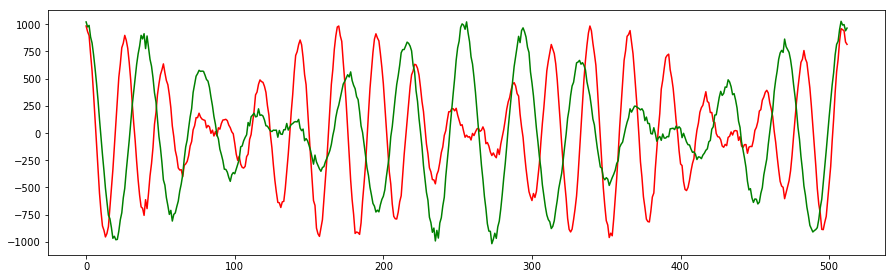

In [231]:
lw =1.5
fig, (axij) = plt.subplots(1, figsize=(15,4.5))
# axij.plot(ijvis_, c='b', label = 'aicraj')
# axij.plot(vis[0], c='g')
# axij.plot(vis[1], c='b')
# axij.plot(vis[2], c='r')
# axij.plot(vis[3], c='g')
# axij.plot(vis[4], c='g')
# axij.plot(vis[5], c='g')
# axij.plot(ijvis_/(sol['etai'] * sol['etaj']), c='b', label = 'aicraj')
# axij.plot(ijvis - ijvis_/(sol['etai'] * sol['etaj']), c='r', label = 'ajcrak')
# axij.plot(jkvis_, c='y')
# axij.plot(klvis, c='m', label = 'akcral')
# axij.plot(klvis_, c='black')

# axij.set_xlim(50,100)

In [ ]:
axij.plot(ijvis, c='b', label = 'aicraj')
axij.plot(ijvis_, c='g')
axij.plot(jkvis, c='r', label = 'ajcrak')
axij.plot(jkvis_, c='y')
axij.plot(klvis, c='m', label = 'akcral')
axij.plot(klvis_, c='black')

axij.plot(ikvis, c='b', label = 'aicrak')
axij.plot(ikvis_, c='g')
axij.plot(jlvis, c='r', label = 'ajcral')
axij.plot(jlvis_, c='y')

axij.plot(ilvis, c='b', label = 'aicral')
axij.plot(ilvis_, c='g')

In [ ]:
ijlog= np.log(ijvis)
jklog= np.log(jkvis)
kllog= np.log(klvis)
ijlog_= np.log(ijvis_)
jklog_= np.log(jkvis_)
kllog_= np.log(klvis_)+np.log(.97)

lw =1.5
fig, (axij) = plt.subplots(1, figsize=(15,4.5))
# axij.plot(ijlog, c='b', label = 'aicraj')
# axij.plot(ijlog_, c='g')
# axij.plot(jklog, c='r', label = 'ajcrak')
# axij.plot(jklog_, c='y')
axij.plot(kllog, c='m', label = 'akcral')
axij.plot(kllog_, c='black')


In [ ]:
ij_jk = ij/jk
jk_kl = jk/kl
ij_kl = ij/kl

ij[2], jk[2],ij_jk[2]

plt.plot(ij_jk)
plt.plot(jk_kl)
plt.plot(ij_kl)

In [ ]:
lvism = np.log(vism)

In [ ]:
np.angle((np.sqrt(2) / 2 ) + (np.sqrt(2)/2)*1j)